# Метод ближайших соседей - исследование и оценка метода  


**Цель работы**: научиться строить модель методом ближайших соседей на реальных данных и правильно определять качество работы модели, а также работать с docker-compose и postgresql.

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение. Цель заключается в том, чтобы создать алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.  


**Задачи работы**:  
- Подключиться к базе данных и ознакомиться с имеющейся информацией.  
- Изучить состав базы данных с помощью ERD-диаграммы.  
- Из данных в базе собрать датасет следующей структуры: `AGREEMENT_RK`, `TARGET`, `AGE`, `SOCSTATUS_WORK_FL`, `SOCSTATUS_PENS_FL`, `GENDER`, `CHILD_TOTAL`, `DEPENDANTS`, `PERSONAL_INCOME`, `LOAN_NUM_TOTAL`, `LOAN_NUM_CLOSED`.  
- Проанализировать и очистить датасет.  
- Построить модель зависимости `TARGET` от остальных параметров методом ближайших соседей.  
- Подобрать оптимальное число ближайших соседей методом `leave-one-out`.  
- Получить качество модели с помощью `F-меры` и `матрицы сопряжённости`.  

Описание данных. Информация находится в файле `database.dump`, который представляет собой резервную копию базы данных `PostgreSQL`. Эта база данных хранит информацию о клиентах банка и их персональные данные, такие как пол, количество детей и другие. Данные представлены в данных таблицах со следующими полями:
1. `d_work`: `ID` — идентификатор социального статуса клиента относительно работы, `COMMENT` — расшифровка статуса.  
2. `d_pens`: `ID` — идентификатор социального статуса, `COMMENT` — расшифровка статуса.  
3. `d_clients`: `ID` — идентификатор записи, `AGE` — возраст клиента, `GENDER` — пол клиента (1 — мужчина, 0 — женщина), `EDUCATION` — образование, `MARITAL_STATUS` — семейное положение, `CHILD_TOTAL` — количество детей клиента, `DEPENDANTS` — количество иждивенцев клиента, `SOCSTATUS_WORK_FL` — социальный статус клиента относительно работы (1 — работает, 0 — не работает), `SOCSTATUS_PENS_FL` — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер), `REG_ADDRESS_PROVINCE` — область регистрации клиента, `FACT_ADDRESS_PROVINCE` — область фактического пребывания клиента, `POSTAL_ADDRESS_PROVINCE` — почтовый адрес области, `FL_PRESENCE_FL` — наличие в собственности квартиры (1 — есть, 0 — нет), `OWN_AUTO` — количество автомобилей в собственности.  
4. `d_agreement`: `AGREEMENT_RK` — уникальный идентификатор объекта в выборке, `ID_CLIENT` — идентификатор клиента, `TARGET` — целевая переменная, отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было).  
5. `d_job`: `GEN_INDUSTRY` — отрасль работы клиента, `GEN_TITLE` — должность, `JOB_DIR` — направление деятельности внутри компании, `WORK_TIME` — время работы на текущем месте (в месяцах), `ID_CLIENT` — идентификатор клиента.  
6. `d_salary`: `ID_CLIENT` — идентификатор клиента, `FAMILY_INCOME` — семейный доход (несколько категорий), `PERSONAL_INCOME` — личный доход клиента (в рублях).  
7. `d_last_credit`: `ID_CLIENT` — идентификатор клиента, `CREDIT` — сумма последнего кредита клиента (в рублях), `TERM` — срок кредита, `FST_PAYMENT` — первоначальный взнос (в рублях).  
8. `d_loan`: `ID_CLIENT` — идентификатор клиента, `ID_LOAN` — идентификатор кредита.  
9. `d_close_loan`: `ID_LOAN` — идентификатор кредита, `CLOSED_FL` — текущий статус кредита (1 — закрыт, 0 — не закрыт).  


## Подготовка  


### Импорт библиотек

In [150]:
# подключение к базе данных
from psycopg2 import connect as pgsql_connect
from psycopg2.extras import NamedTupleCursor

# работа с данными и визуализация
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

### Подключение к базе данных  


In [152]:
class PostgreSQLConnection:
    """Класс для подключения к базе данных PostgreSQL."""

    def __init__(self, dbname: str, user: str, password: str, host: str, port: str) -> None:
        """При инициализации класса необходимо задать данные для подключения к базе данных:  
        * `host` и `port` - адрес и порт сервера;  
        * `dbname` - название базы данных;  
        * `user` и `password` - логин и пароль к базе данных.
        """
        self.connection_parameters = {'host': host, 'port': port, 'dbname': dbname, 
                                      'user': user, 'password': password}
    
    def request(self, query: str) -> pd.DataFrame:
        """Выполняет запрос и возвращает результат в виде pandas.DataFrame."""
        with pgsql_connect(**self.connection_parameters) as connection:
            with connection.cursor(cursor_factory=NamedTupleCursor) as cursor:
                cursor.execute(query)
                response = pd.DataFrame(cursor.fetchall())
        return response

In [153]:
database = PostgreSQLConnection(dbname='postgres', user='postgres', password='1234', host='127.0.0.1', port='5432')

In [154]:
# Посмотрим на доступные таблицы
database.request("SELECT tablename FROM pg_tables WHERE schemaname='public'").T

,0,1,2,3,4,5,6,7,8
tablename,d_clients,d_agreement,d_last_credit,d_job,d_loan,d_close_loan,d_salary,d_pens,d_work


ER-диаграмма базы данных выглядит так:

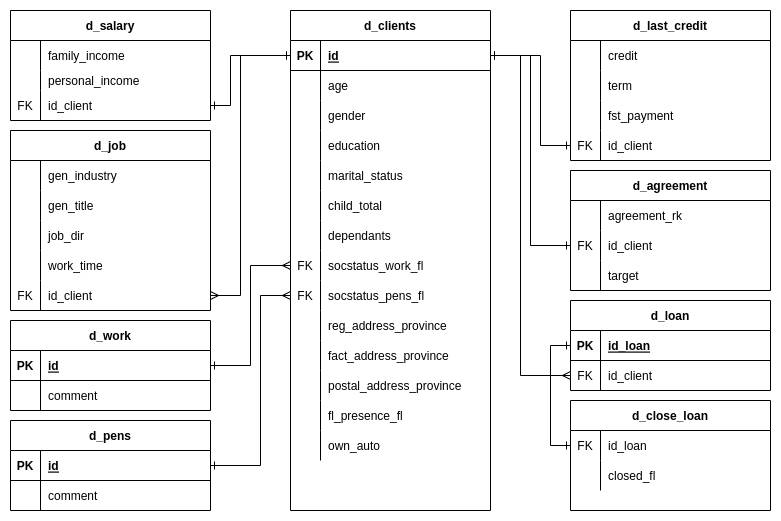

### Получение данных  


In [155]:
get_dataset_query = '''
    WITH loan_count AS (
        SELECT 
            l.id_client, 
            COUNT(l.id_loan) AS loan_num_total, 
            SUM(cl.closed_fl) AS loan_num_closed
        FROM d_loan AS l
        LEFT JOIN d_close_loan AS cl
            ON l.id_loan = cl.id_loan
        GROUP BY l.id_client)

    SELECT 
        a.agreement_rk, 
        a.target, 
        c.age, 
        c.socstatus_work_fl, 
        c.socstatus_pens_fl, 
        c.gender, 
        c.child_total, 
        c.dependants, 
        s.personal_income, 
        l.loan_num_total, 
        l.loan_num_closed
    
    FROM d_agreement AS a
    LEFT JOIN d_clients AS c
        ON a.id_client = c.id
    LEFT JOIN d_salary AS s
        ON a.id_client = s.id_client
    LEFT JOIN loan_count AS l
        ON a.id_client = l.id_client
'''

In [156]:
data = database.request(get_dataset_query).set_index('agreement_rk')

In [157]:
data.head(10)

,target,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants,personal_income,loan_num_total,loan_num_closed
agreement_rk,,,,,,,,,,
62246916,0,42,2,1,0,0,0,20000.0,1,0
67011502,0,24,2,1,1,0,0,14000.0,1,1
63918955,0,28,2,1,0,0,0,15000.0,1,0
63633352,0,33,2,1,0,0,0,20000.0,1,1
62024377,0,47,2,1,1,2,0,25000.0,1,0
61471412,0,43,2,1,0,2,2,10000.0,2,2
64444762,0,25,2,1,0,0,0,14000.0,1,0
61849152,1,57,1,2,1,3,0,7000.0,1,1
74464246,0,29,2,1,1,1,1,30000.0,2,2


## Анализ и подготовка данных  


In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15523 entries, 62246916 to 61847017
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   target             15523 non-null  object
 1   age                15523 non-null  object
 2   socstatus_work_fl  15523 non-null  object
 3   socstatus_pens_fl  15523 non-null  object
 4   gender             15523 non-null  object
 5   child_total        15523 non-null  object
 6   dependants         15523 non-null  object
 7   personal_income    15523 non-null  object
 8   loan_num_total     15523 non-null  int64 
 9   loan_num_closed    15523 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.3+ MB


### Очистка и форматирование данных  


In [159]:
print(f'Количество дубликатов в датасете: {data.duplicated().sum()}')
data = data.drop_duplicates()
print('Удалено!')

Количество дубликатов в датасете: 3601
Удалено!


In [160]:
print(f'Приведём типы всех колонок к int.')
data = data.astype(int)
print(f'Сделано!')

Приведём типы всех колонок к int.
Сделано!


In [161]:
print(f'Пропущенных данных нет.')

Пропущенных данных нет.


In [162]:
print(f'Категориальными признаками являются gender, socstatus_work_fl и socstatus_pens_fl.\n'
      f'Но так как они имеют всего по два значения, их удобно закодировать как 1 и 0.')

Категориальными признаками являются gender, socstatus_work_fl и socstatus_pens_fl.
Но так как они имеют всего по два значения, их удобно закодировать как 1 и 0.


In [163]:
data['gender'].value_counts()

1    7644
0    4278
Name: gender, dtype: int64

In [164]:
data['socstatus_work_fl'].value_counts()

2    10684
1     1238
Name: socstatus_work_fl, dtype: int64

In [165]:
data['socstatus_pens_fl'].value_counts()

1    10042
2     1880
Name: socstatus_pens_fl, dtype: int64

In [166]:
data['socstatus_work_fl'] = (data['socstatus_work_fl'] == 2).astype(int)
data['socstatus_pens_fl'] = (data['socstatus_pens_fl'] == 1).astype(int)

### Анализ данных  


In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11922 entries, 62246916 to 61847017
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   target             11922 non-null  int64
 1   age                11922 non-null  int64
 2   socstatus_work_fl  11922 non-null  int64
 3   socstatus_pens_fl  11922 non-null  int64
 4   gender             11922 non-null  int64
 5   child_total        11922 non-null  int64
 6   dependants         11922 non-null  int64
 7   personal_income    11922 non-null  int64
 8   loan_num_total     11922 non-null  int64
 9   loan_num_closed    11922 non-null  int64
dtypes: int64(10)
memory usage: 1.0+ MB


In [168]:
data.describe()

,target,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants,personal_income,loan_num_total,loan_num_closed
count,11922.000000,11922.000000,11922.000000,11922.000000,11922.000000,11922.000000,11922.000000,11922.000000,11922.000000,11922.000000
mean,0.139909,41.717245,0.896158,0.842308,0.641168,1.176732,0.657272,14151.010736,1.467791,0.845915
std,0.346908,11.518650,0.305068,0.364467,0.479678,1.031775,0.838809,9751.060576,0.861333,1.047722
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,0.000000
25%,0.000000,32.000000,1.000000,1.000000,0.000000,0.000000,0.000000,8000.000000,1.000000,0.000000
50%,0.000000,41.000000,1.000000,1.000000,1.000000,1.000000,0.000000,12000.000000,1.000000,1.000000
75%,0.000000,51.000000,1.000000,1.000000,1.000000,2.000000,1.000000,17000.000000,2.000000,1.000000
max,1.000000,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,250000.000000,11.000000,11.000000


In [169]:
print(f'Целевая переменная распределена неравномерно.')
data['target'].value_counts(normalize=True).apply(lambda x: f'{x*100:0.2f}%')

Целевая переменная распределена неравномерно.


0    86.01%
1    13.99%
Name: target, dtype: object

Во многих колонках присутствуют выбросы:


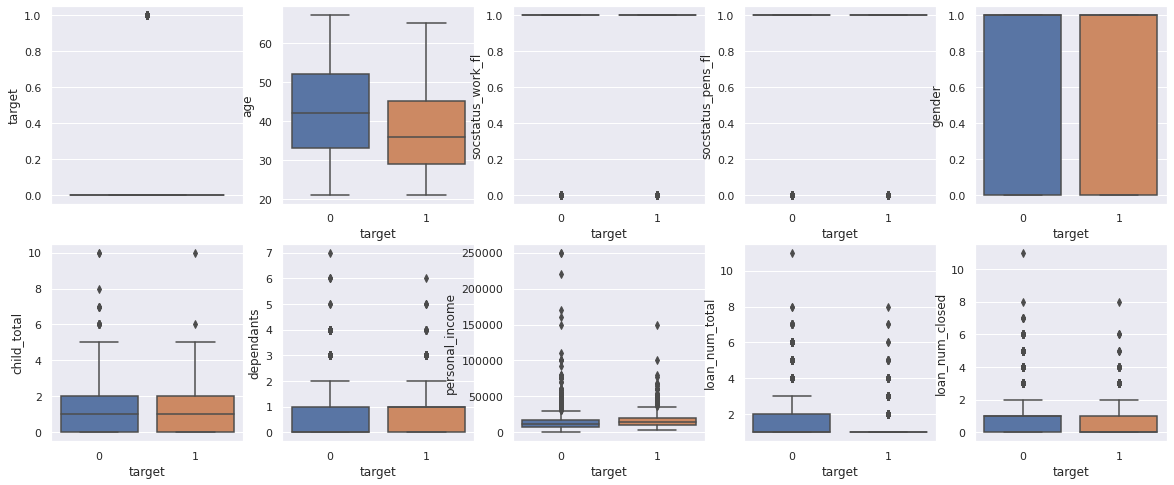

In [170]:
print(f'Во многих колонках присутствуют выбросы:')
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, col in enumerate(data.columns):
    sns.boxplot(data=data, x=(None if col=='target' else 'target'), y=col, ax=axes[i//5][i%5])

Таблица корреляции:
Целевая переменная ни с чем не коррелирует.


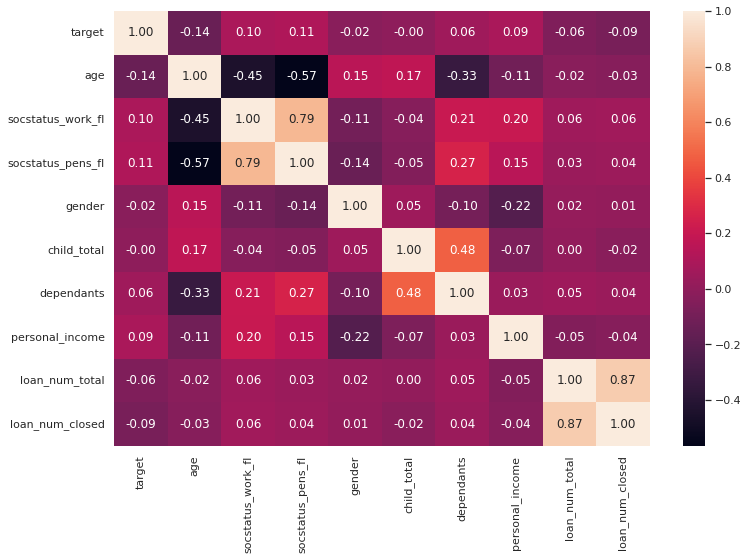

In [171]:
print(f'Таблица корреляции:')
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt='0.2f')
print(f'Целевая переменная ни с чем не коррелирует.')

Взаимосвязь признаков и целевой переменной.


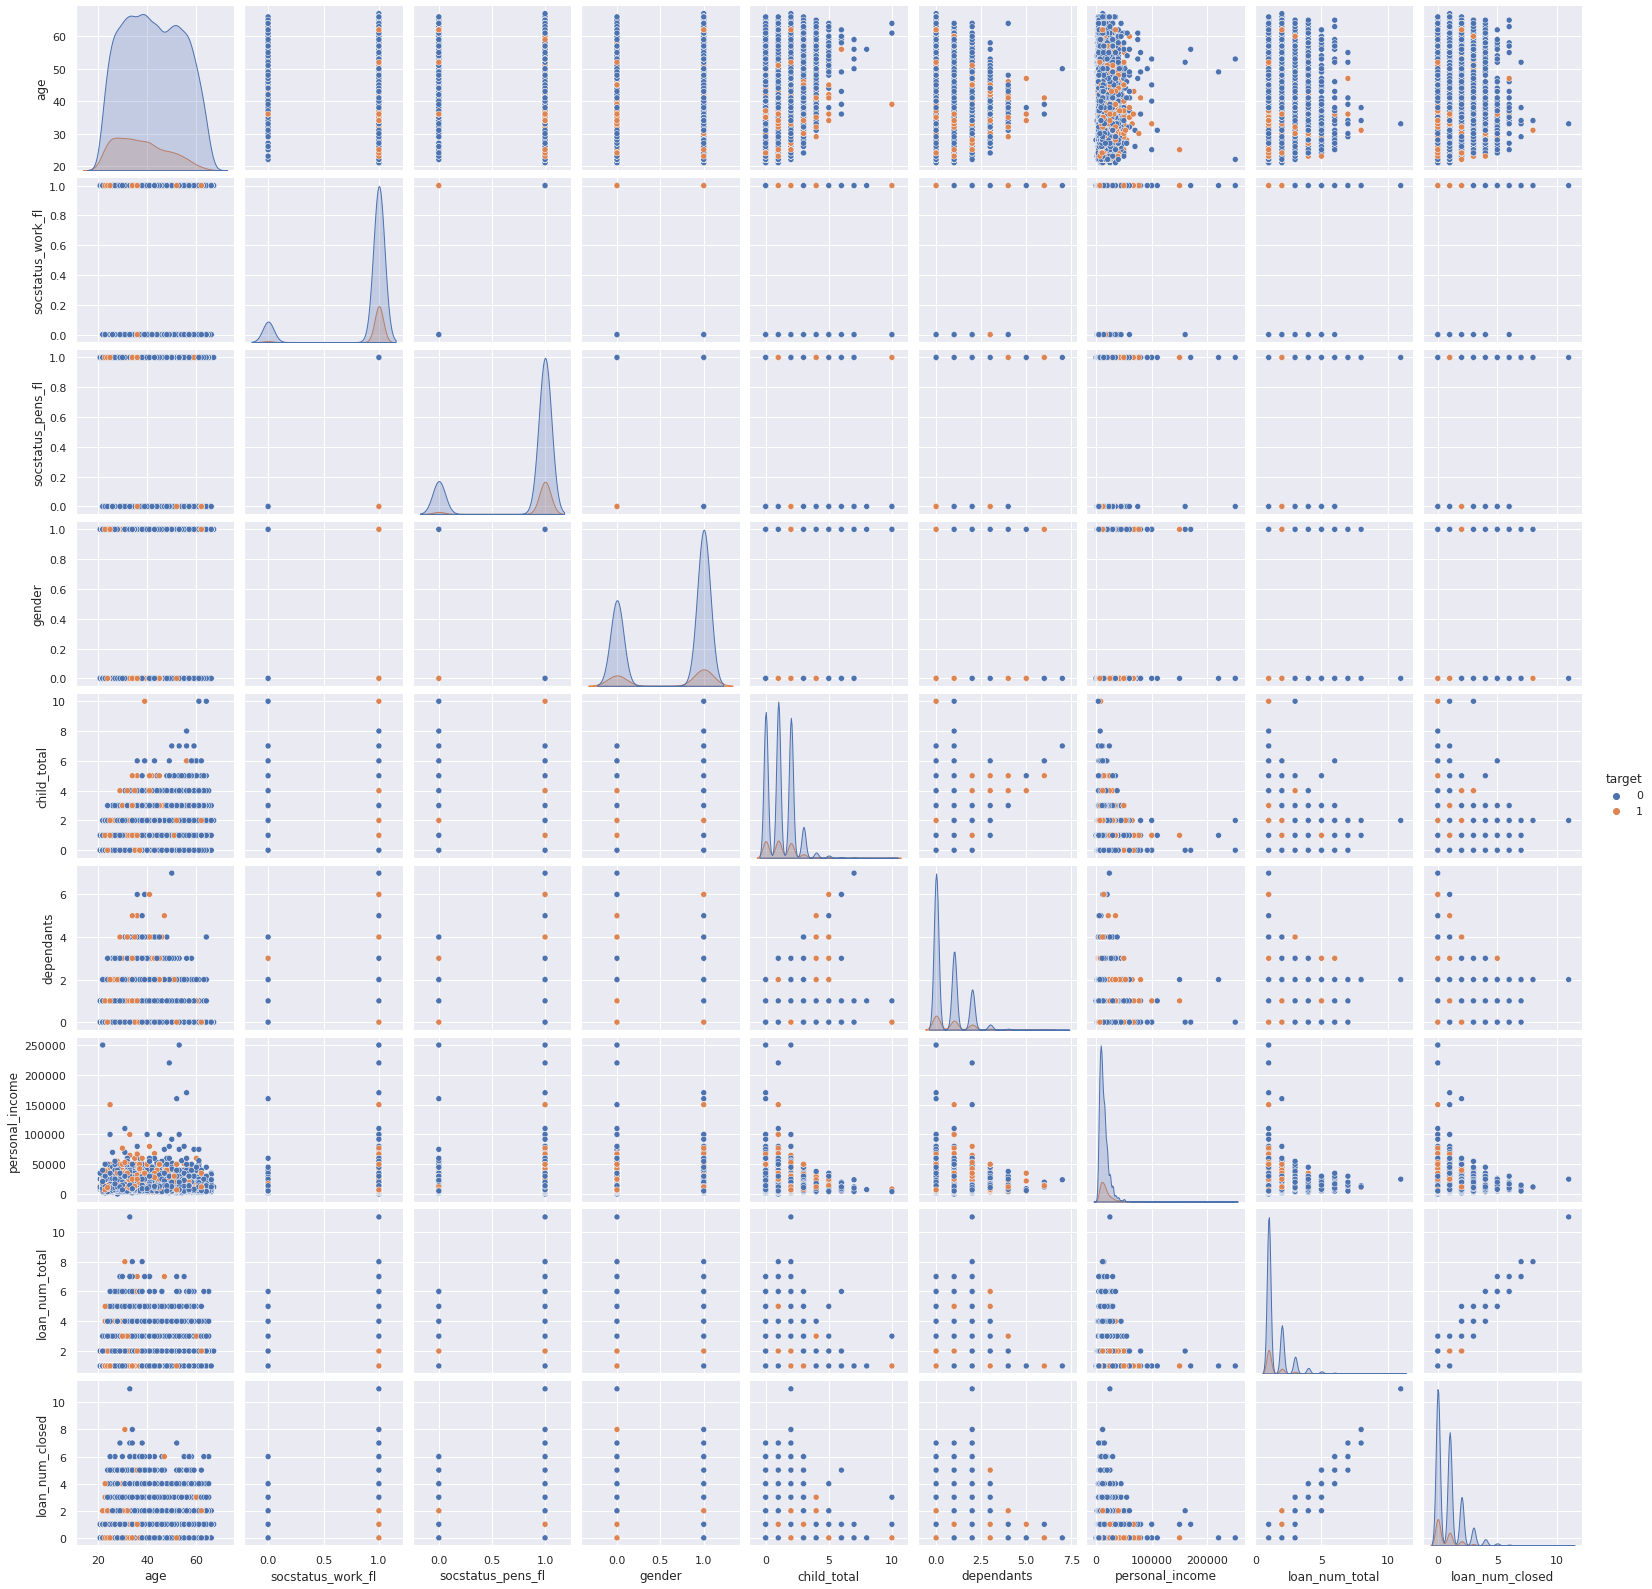

In [172]:
print(f'Взаимосвязь признаков и целевой переменной.')
sns.pairplot(data, hue='target');

Выводы: 
+ пропущенных данных не было, но было большое количество дубликатов, которые были удалены;
+ целевая переменная распределена неравномерно, только 14% клиентов откликаются на предложение о новой услуге;
+ в датасете 6 численных и 3 бинарных признака; 
+ в данных присутствуют выбросы, но они будут обработаны при нормализации с помощью RobustScaler;
+ похоже люди более младшего возраста более склонны к отклику на предложение;
+ и так же люди с более высоким доходом более склонны к отклику на предложение;
+ похоже люди менее склонны откликнуться на предложение, если у них больше одного кредита;
+ целевая переменная не коррелирует ни с одним признаком;

### Создание дополнительных признаков

In [173]:
data['0.5**age'] = 0.5**data['age']
data['age**0.33'] = data['age'] ** 0.33
data['personal_income**2'] = data['personal_income'] ** 2
data['personal_income**3'] = data['personal_income'] ** 3
data['child_total**4'] = data['child_total']**4.0
data['pi_by_d/c'] = data['personal_income'] * (data['dependants'] / data['child_total']).replace({float('nan'): 0.0, float('inf'): 0.0})
data['loan_num_total**2'] = data['loan_num_total'] ** 2
data['2**loan_num_total'] = 2**data['loan_num_total']
data['loan_ratio**0.5'] = (data['loan_num_total'] / data['loan_num_closed']).replace({float('nan'): 0.0, float('inf'): 0.0}) ** 0.5

# без этих признаков модель показывает немного лучше результат
data = data.drop(columns=['child_total', 'gender'])

## Моделирование  


### Разделение данных  


In [174]:
x = data.copy()
y = x.pop('target')

print(f'x.shape={x.shape}, y.shape={y.shape}')

x.shape=(11922, 16), y.shape=(11922,)


In [175]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

print(f'train shapes: {x_train.shape}, {y_train.shape}')
print(f'test shapes: {x_test.shape}, {y_test.shape}')

train shapes: (8941, 16), (8941,)
test shapes: (2981, 16), (2981,)


### Обучение и оценка модели по умолчанию  


In [176]:
# Обучим модель с параметрами по умолчанию 

knn = Pipeline(steps=[
    ('scaler', RobustScaler()), 
    ('model', KNeighborsClassifier()), 
])
knn.fit(x_train, y_train);

In [177]:
# Оценим модель

prediction_train = knn.predict(x_train)
print('Матрица ошибок на тренировочных данных:')
print(confusion_matrix(y_train, prediction_train))
print(f'train accuracy = {accuracy_score(y_train, prediction_train)}')
print(f'train f1_score = {f1_score(y_train, prediction_train)}')

prediction_test = knn.predict(x_test)
print('\nМатрица ошибок на тестовых данных:')
print(confusion_matrix(y_test, prediction_test))
print(f'test accuracy = {accuracy_score(y_test, prediction_test)}')
print(f'test f1_score = {f1_score(y_test, prediction_test)}')

Матрица ошибок на тренировочных данных:
[[7580  110]
 [1092  159]]
train accuracy = 0.8655631361145286
train f1_score = 0.20921052631578946

Матрица ошибок на тестовых данных:
[[2479   85]
 [ 395   22]]
test accuracy = 0.838980207983898
test f1_score = 0.08396946564885498


### Подбор параметров модели  



In [181]:
scores = {'k': list(), 'train_accuracy': list(), 'train_f1': list(), 'test_accuracy': list(), 'test_f1': list()}
for k in range(1, 100, 2):
    knn = Pipeline(steps=[
        ('scaler', RobustScaler()), 
        ('model', KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree'))])
    cv = 20  # для использования метода leave-one-out достаточно заменить эту строку на cv=LeaveOneOut(),
             # но в таком случае будут сложности с расчетом метрики f1, которая важна для анализа работы модели,
             # и время поиска подходящего k значительно увеличится, а результат будет тем же, что и при cv=20
    
    cv_results = cross_validate(knn, x_train, y_train, return_train_score=True, cv=cv, 
                                scoring=['accuracy', 'f1'], n_jobs=-1, error_score=0.0)
    scores['k'].append(k)
    scores['train_accuracy'].append(cv_results['train_accuracy'].mean())
    scores['train_f1'].append(cv_results['train_f1'].mean())
    scores['test_accuracy'].append(cv_results['test_accuracy'].mean())
    scores['test_f1'].append(cv_results['test_f1'].mean())
scores = pd.DataFrame(scores)

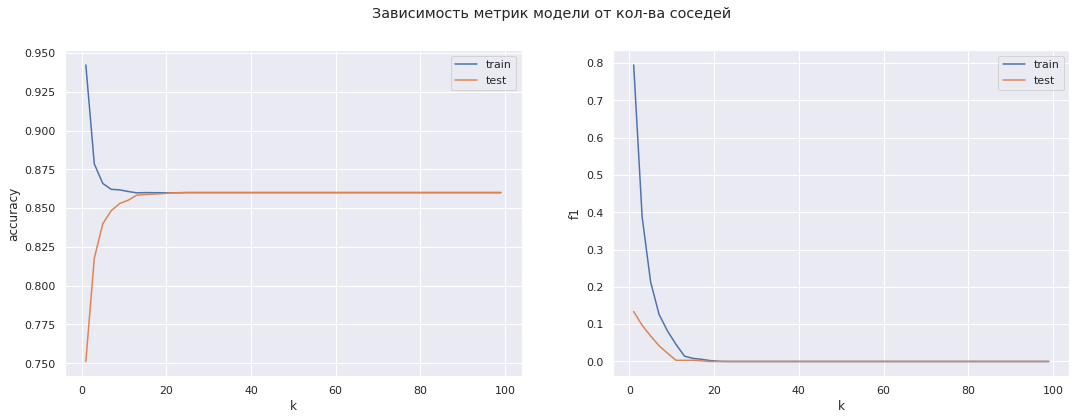

In [182]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.lineplot(data=scores, x='k', y='train_accuracy', label='train', ax=axes[0])
sns.lineplot(data=scores, x='k', y='test_accuracy', label='test', ax=axes[0])
axes[0].set_ylabel('accuracy')

sns.lineplot(data=scores, x='k', y='train_f1', label='train', ax=axes[1])
sns.lineplot(data=scores, x='k', y='test_f1', label='test', ax=axes[1])
axes[1].set_ylabel('f1')

fig.suptitle('Зависимость метрик модели от кол-ва соседей')
plt.show()

In [183]:
# Обучим лучшую модель

knn = Pipeline(steps=[
    ('scaler', RobustScaler()), 
    ('model', KNeighborsClassifier(20, algorithm='kd_tree')), 
])
knn.fit(x_train, y_train);

In [184]:
# Оценим модель

prediction_train = knn.predict(x_train)
print('Матрица ошибок на тренировочных данных:')
print(confusion_matrix(y_train, prediction_train))
print(f'train accuracy = {accuracy_score(y_train, prediction_train)}')
print(f'train f1_score = {f1_score(y_train, prediction_train)}')

prediction_test = knn.predict(x_test)
print('\nМатрица ошибок на тестовых данных:')
print(confusion_matrix(y_test, prediction_test))
print(f'test accuracy = {accuracy_score(y_test, prediction_test)}')
print(f'test f1_score = {f1_score(y_test, prediction_test)}')

Матрица ошибок на тренировочных данных:
[[7690    0]
 [1251    0]]
train accuracy = 0.8600827647914103
train f1_score = 0.0

Матрица ошибок на тестовых данных:
[[2564    0]
 [ 417    0]]
test accuracy = 0.8601140556860114
test f1_score = 0.0


## Выводы  


Модель работает плохо. Даже создание дополнительных признаков позволило лишь немного увеличить метрику test_f1 на модели с дефолтными гиперпараметрами (с 0.035 до 0.084). И использование параметра модели weights='distance' тоже не увеличивает качество модели.  

Модель с k=5 по умолчанию имеет accuracy=0.85. Может показаться, что это удовлетворительная точность, но целевая переменная в задаче распределена неравномерно, поэтому даже предсказание для всех объектов значения 0 даст точность accuracy=0.86. Значение f-меры, которая лучше подходит для несбалансированных целевых переменных, составляет test_f1=0.084, что говорит о плохом качестве модели.  

Подобрать правильное значение параметра k не представляется хорошей идеей. При оптимизации метрики accuracy, модель с k=20 уже начинает предсказывать для всех объектов 0, то есть в данном случае модель попросту бесполезна. При оптимизации метрики f1, лучшей моделью оказывается модель с k=1, но в таком случае f1=0.12 - и это плохой результат, и модель явно переобучается.  

Скорее всего с большим количеством данных, которые есть в базе данных, но не попали в обучающую выборку, модель будет работать лучше. Возможно, что для этой задачи лучше подошёл бы какой-нибудь иной алгоритм вместо k-ближайших соседей.  